In [67]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}
import matplotlib as mpl
from scipy.optimize import curve_fit

plt.rcParams["axes.prop_cycle"] = plt.cycler("color", plt.cm.viridis(np.linspace(0,1,12)))
# plt.rcParams["axes.prop_cycle"] = plt.cycler("color", plt.cm.tab10.colors)

# runstr='Dry'
# dftab=pd.read_pickle('dfs/df_run_02_dry_delta_tab.pkl')
# df=pd.read_pickle('dfs/df_run_02_dry.pkl')

runstr='Wet'
dftab=pd.read_pickle('dfs/df_run_02_land_delta_tab.pkl')
# # df=pd.read_pickle('dfs/df_run_02_land.pkl')

f=2*np.sin(30*(np.pi/180))*7.2921150E-5
fs=8 #font size
dftab['tal']=round((dftab.t-dftab.tlf)*24,2)
dftab['r']=round(dftab['r'],3)
dftab['rV10max']=round(dftab['rV10max'],3)
r0=dftab.r.unique()[0]

In [68]:
def plot_ts(ax,d):
    ax.plot(tlfs,d.dat,'kx-')
    ax.grid(True)
    ax.set_ylabel(d.lab)
    ax.set_xlabel('t$_{LF}$ (d)')
    
class Var:
    def __init__(self,vid,vdat,vlab):
        self.id=vid
        self.dat=vdat
        self.lab=vlab

class Pltdat:
    def __init__(self,x,y,eq):
        self.x=x
        self.y=y
        self.eq=eq
        
def get_a_Pdmax(x,y,ax=False):  
    xcol = np.array(x)[:,np.newaxis]
    m, _, _, _ = np.linalg.lstsq(xcol, y,rcond=None)
    if ax:
        ax.plot(x,y,'r.')
        
        ax.set_title('t$_{lf}$='+str(tlf))
        ax.grid(True)
        ax.set_xlabel('$\hat{P}^2$')
        ax.set_ylabel('$vr_{colRmax} (m/s)$')
        r2=np.corrcoef(x,y)[0,1]**2
        ax.text(0.05,0.85,"R$^2$={:2.2f}".format(r2),transform=ax.transAxes,fontsize=fs)
        
        ax.set_xlim((0,ax.get_xlim()[1]))
        ax.set_ylim((0,ax.get_ylim()[1]))
        xl=np.array(ax.get_xlim())
#         ax.plot(xl,m*xl+c,'k',lw=2)
        ax.plot(xl,m*xl,'k',lw=2)
        ax.plot(x,y,'r.')
        
    return(m[0])

def fit_thalf(t,y,ylab,ax=False):
    ly = np.log(y)
    K, A_log = np.polyfit(t, ly, 1)
    A = np.exp(A_log)
    thalf=-np.log(2)/K
    yf=np.exp(A_log+t*K)
    
    if ax:
        ax.plot(t*24,y)
        ax.plot(t*24,yf,'--')
        ax.grid(True)
        ax.set_title('t$_{lf}$='+str(tlf))
        ax.set_xlabel('t (h)')
        ax.set_ylabel(ylab)
        ax.set_xlim((0,12))        
    return(thalf)

def fit_thalf_alg(t,y,ylab,ax=False):
    def algd(x,k,a):
        return(1/(k*x+a))
#     print(t)
#     t=t-t.values[0]
    pa0=[0.07602148, 0.01205749]
    fita,fitcova=curve_fit(algd,t,y,p0=pa0)
    thalf=fita[1]/fita[0]
    yf=algd(t,fita[0],fita[1])
#     print(fita) 
    if ax:
        ax.plot(t*24,y,'k')
        ax.plot(t*24,yf,'--r')
        ax.grid(True)
        ax.set_title('t$_{lf}$='+str(tlf))
        ax.set_xlabel('t (h)')
        ax.set_ylabel(ylab)
        ax.set_xlim((0,12))
        ax.set_ylim((0,0.1))
    return(thalf)

Getting vars
CoV(a)=0.29733433150008104
Calculating half lives
plotting time series


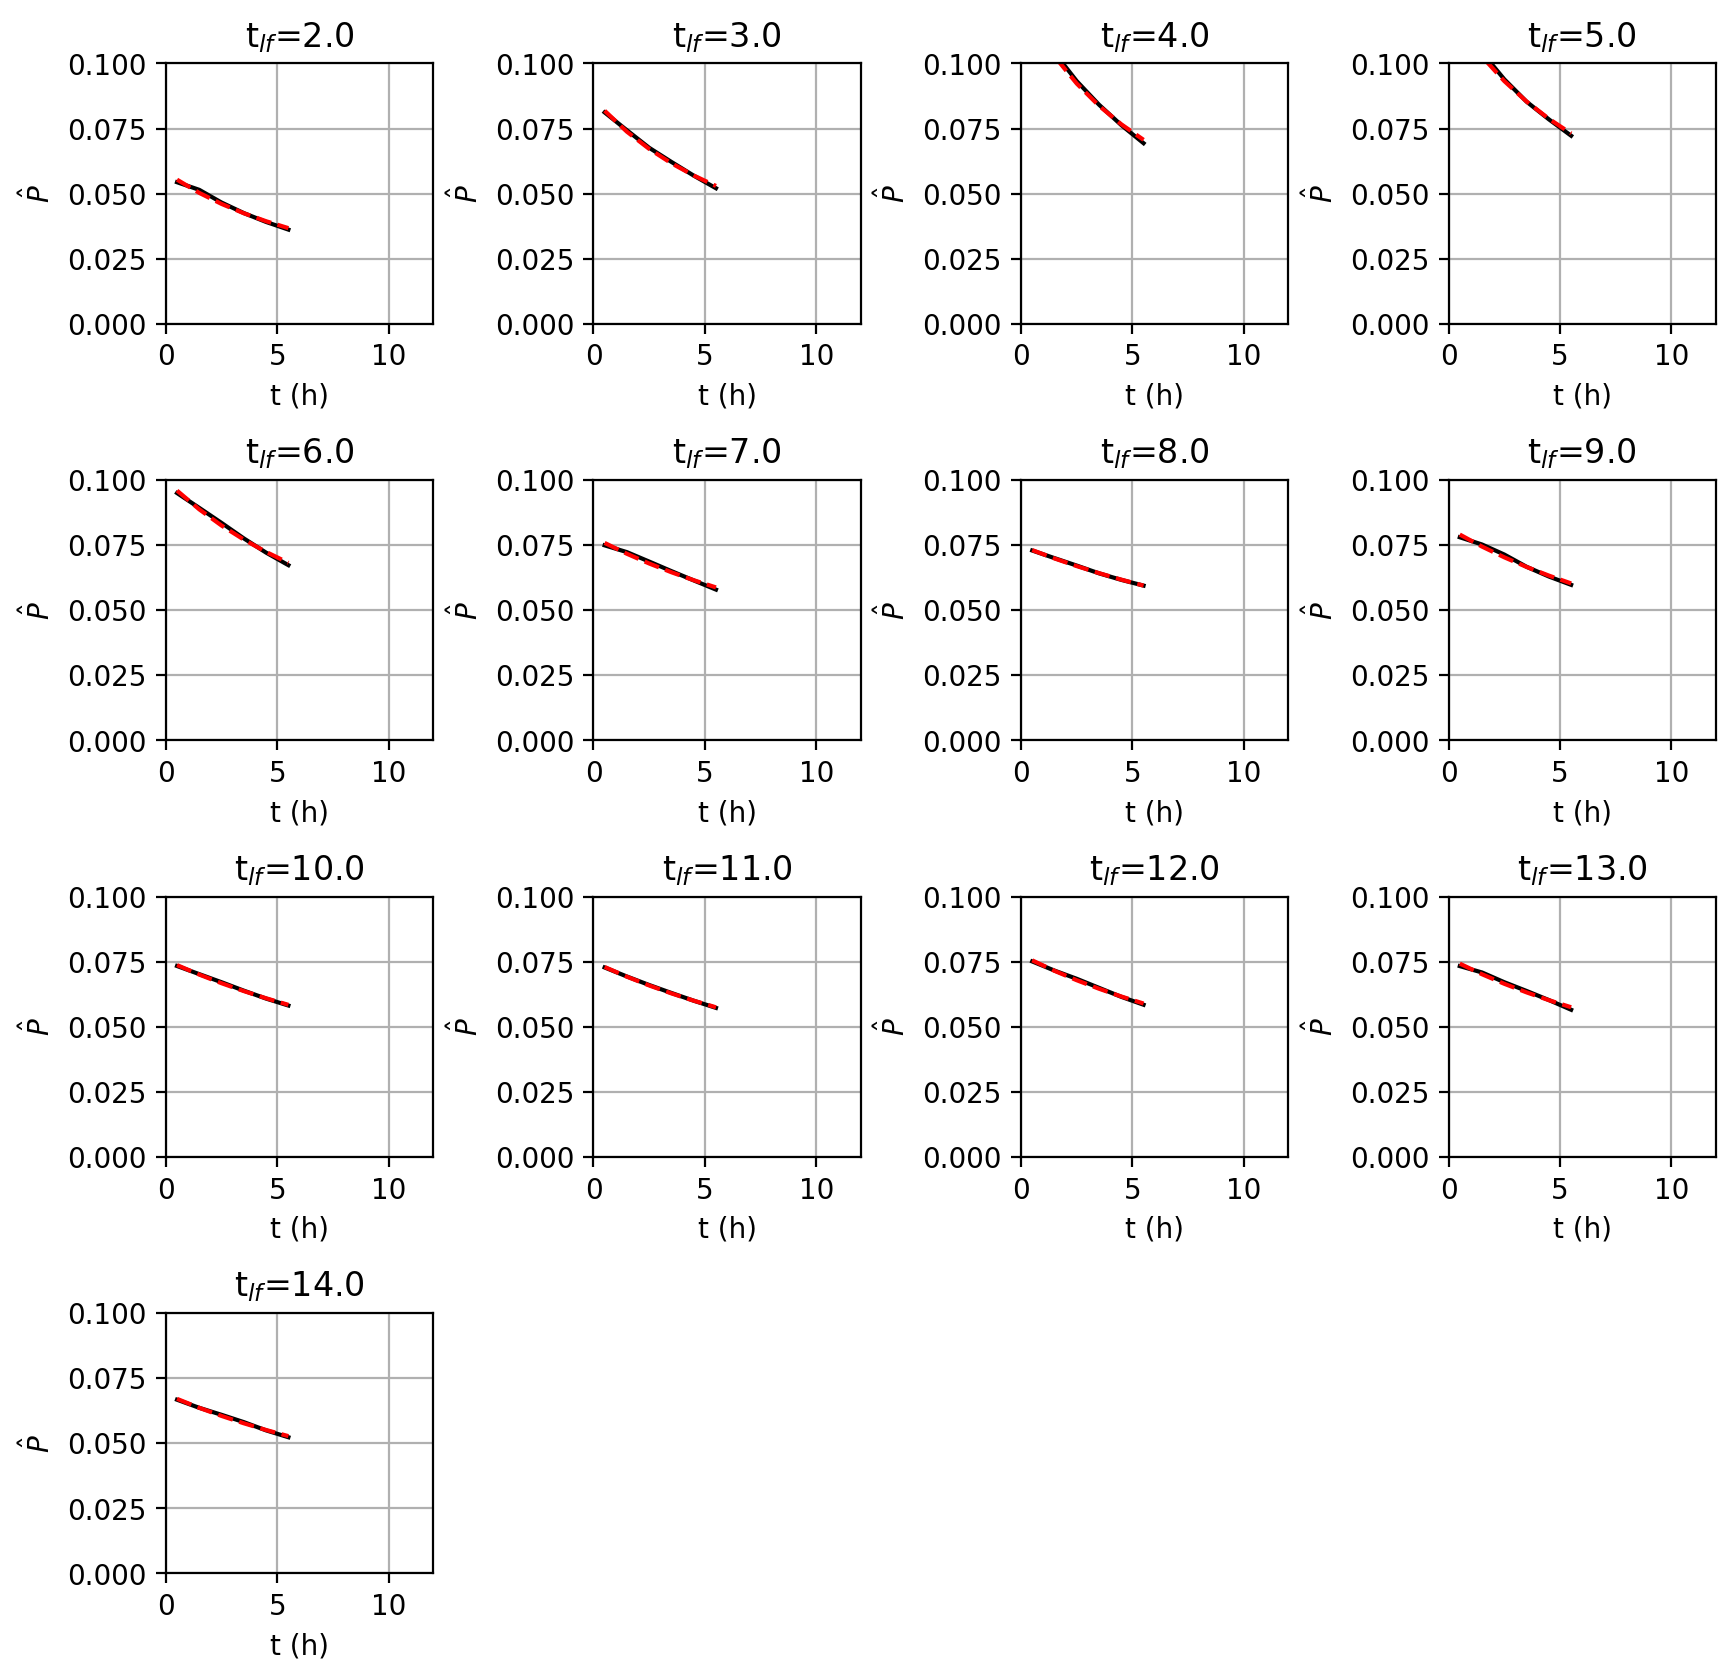

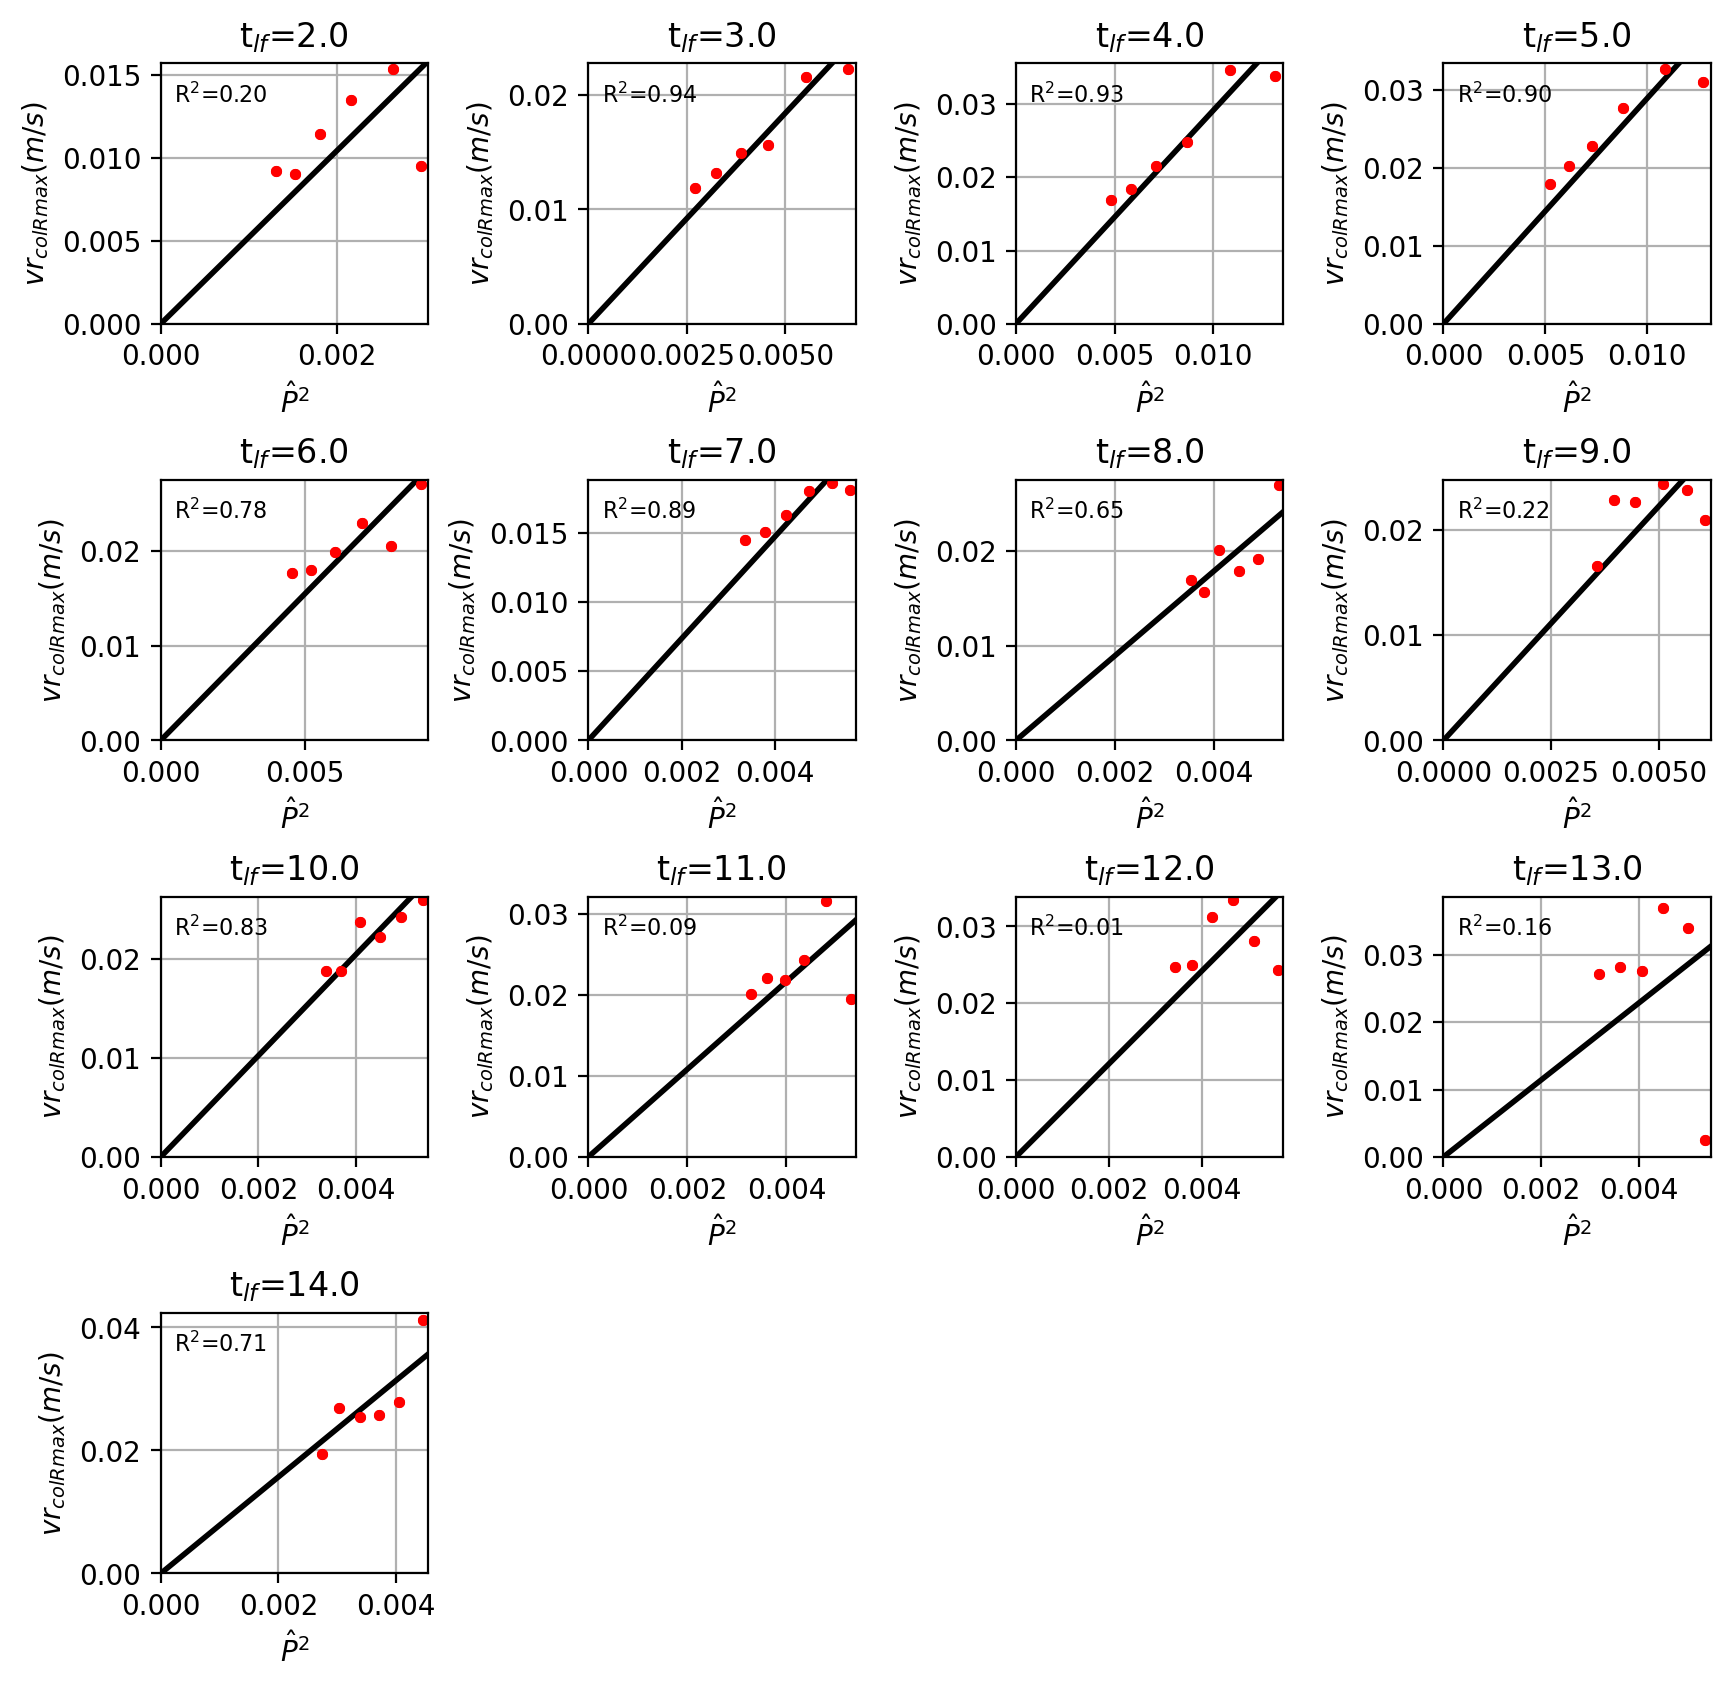

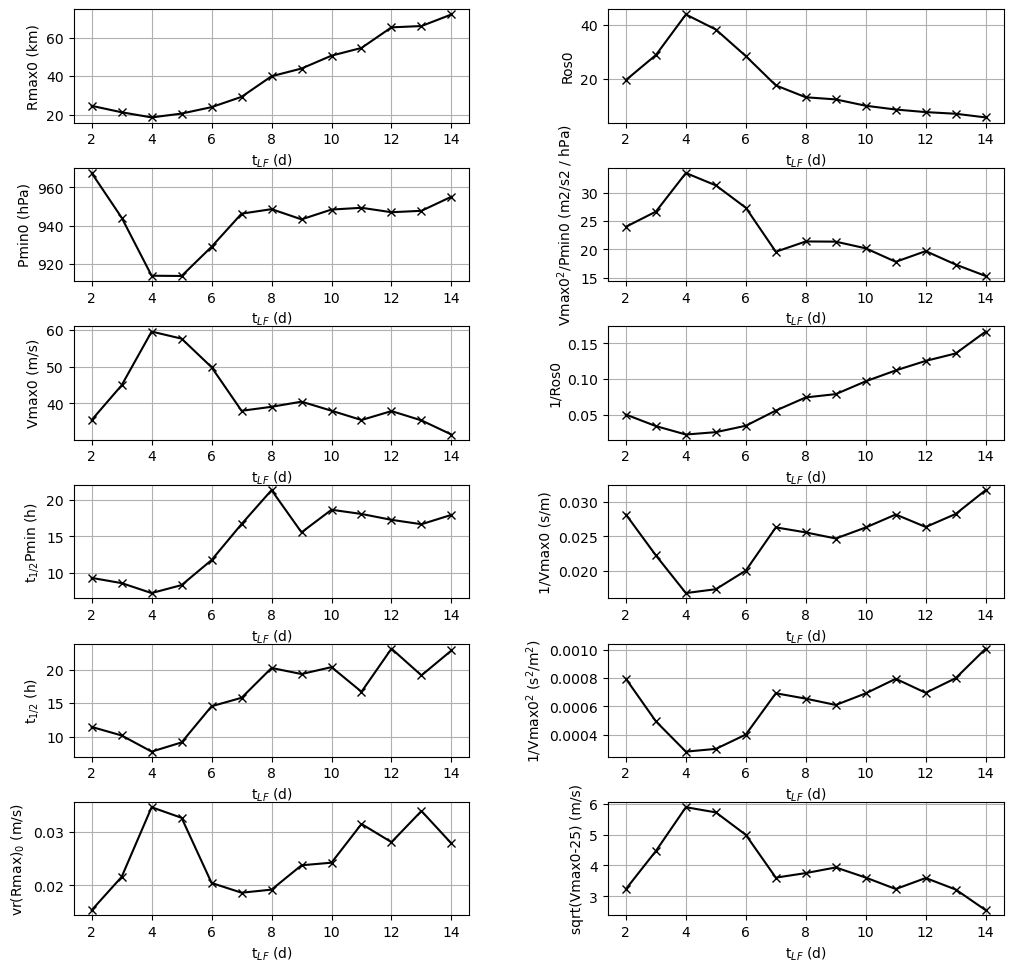

In [69]:
figs=[]; axss=[]
for i in range(2):
    fig,axs=plt.subplots(4,4,sharex=False,dpi=200,figsize=(10,10))
    plt.subplots_adjust(hspace=0.6,wspace=0.6)
    for i in range(13,len(axs.flat)):
        axs.flat[i].axis('off')
    figs.append(fig)
    axss.append(axs)
    
fig5,axs5=plt.subplots(6,2,sharex=False,dpi=100,figsize=(12,12))
plt.subplots_adjust(hspace=0.4,wspace=0.35)
# for i in range(11,len(axs5.flatten(order='F'))):
#     axs5.flatten(order='F')[i].axis('off')

a_vrPd0=[];thP=[];a_vrr=[];Rmax0=[];Pmin0=[];vrRmax0=[];Vmax0=[];Ros0=[];a_vrPhat2=[];
Pe=1020
tmind=0
tmaxd=6
tmina=0
tmaxa=6



tlfs=dftab.tlf.unique()
# tlfs=np.delete(tlfs,11)

print('Getting vars')
for n,tlf in enumerate(tlfs):

    # get 'initial' params
    df0=dftab.query('tlf==@tlf & tal==1.5')
    df0=df0.iloc[np.argmin((df0.r-df0.rV10max).abs())]
    rmax_tlf=df0.r

    Pmin0.append(df0.Pmin)
    Rmax0.append(df0.rV10max)
    Vmax0.append(df0.V10max)
    Ros0.append(Vmax0[-1]/(1000*Rmax0[-1]*f))
        
    # get vr
    df0=dftab.query('tlf==@tlf & tal==1.5')
    df0=df0.iloc[np.argmin((df0.r-df0.rV10max).abs())]
    vrRmax0.append(df0.vrcol)
        
    # fit decay
    dfdt=dftab.query('tlf==@tlf & r == @r0 & tal>=@tmind & tal <= @tmaxd')     
    thP.append(24*fit_thalf_alg(dfdt.tal/24,(Pe-dfdt.Pmin)/Pe,ax=axss[0].flat[n],ylab='$\hat{P}$'))
    
    # fit a
    dfat=dftab.query('tlf==@tlf & r == @rmax_tlf & tal>=@tmind & tal <= @tmaxd') 
    x=((Pe-dfat.Pmin)/Pe)**2
    y=dfat.vrcol
    a_vrPhat2.append(get_a_Pdmax(x,y,ax=axss[1].flat[n]))

Pmin0=np.array(Pmin0)
Vmax0=np.array(Vmax0)
Rmax0=np.array(Rmax0)
Ros0=np.array(Ros0)

a=a_vrPhat2
print('CoV(a)='+str(np.std(a)/np.mean(a)))

print('Calculating half lives')

def calc_thalf(Rmax,Phat,vrRmax0):
    return(1000*Rmax*Phat/(2*vrRmax0))

tha=[calc_thalf(Rmax0a,(Pe-Pmin0a)/Pe,vrRmax0a)/(60*60) for Rmax0a,Pmin0a,vrRmax0a in zip (Rmax0,Pmin0,vrRmax0)]

vars=(
    Var('Rmax0',Rmax0,'Rmax0 (km)'),
    Var('Pmin0',Pmin0,'Pmin0 (hPa)'),
    Var('Vmax0',Vmax0,'Vmax0 (m/s)'),
    Var('thP',thP,'t$_{1/2}$Pmin (h)'),
    Var('tha',tha,'t$_{1/2}$ (h)'),
#     Var('tha_aRmaxPhat',tha_aRmaxPhat,'t$_{1/2}$aRmaxPhat (h)'),
#     Var('a_vrPhat2',a_vrPhat2,'a vr/$\hat{P}^2$ (m/s)'),
    Var('vrRmax0',vrRmax0,'vr(Rmax)$_0$ (m/s)'),
    Var('Ros0',Ros0,'Ros0'),
    Var('V2overP',Vmax0**2/(Pe-Pmin0),'Vmax0$^2$/Pmin0 (m2/s2 / hPa)'),
    Var('Ros0rec',1/Ros0,'1/Ros0'),
    Var('Vmax0rec',1/Vmax0,'1/Vmax0 (s/m)'),
    Var('Vmax0rec2',1/Vmax0**2,'1/Vmax0$^2$ (s$^2$/m$^2$)'),
    Var('sqrtVmax0',np.sqrt(Vmax0-25),'sqrt(Vmax0-25) (m/s)'),
)

# if runstr=='Wet':
#     vars=vars+(Var('thR',thR,'t$_{1/2}$Rain (h)'),)

vd = {var.id: var for var in vars}

print('plotting time series')
axsf=axs5.flatten(order='F')
for ax,d in zip(axsf,vars):
    plot_ts(ax,d)

plotting scatters


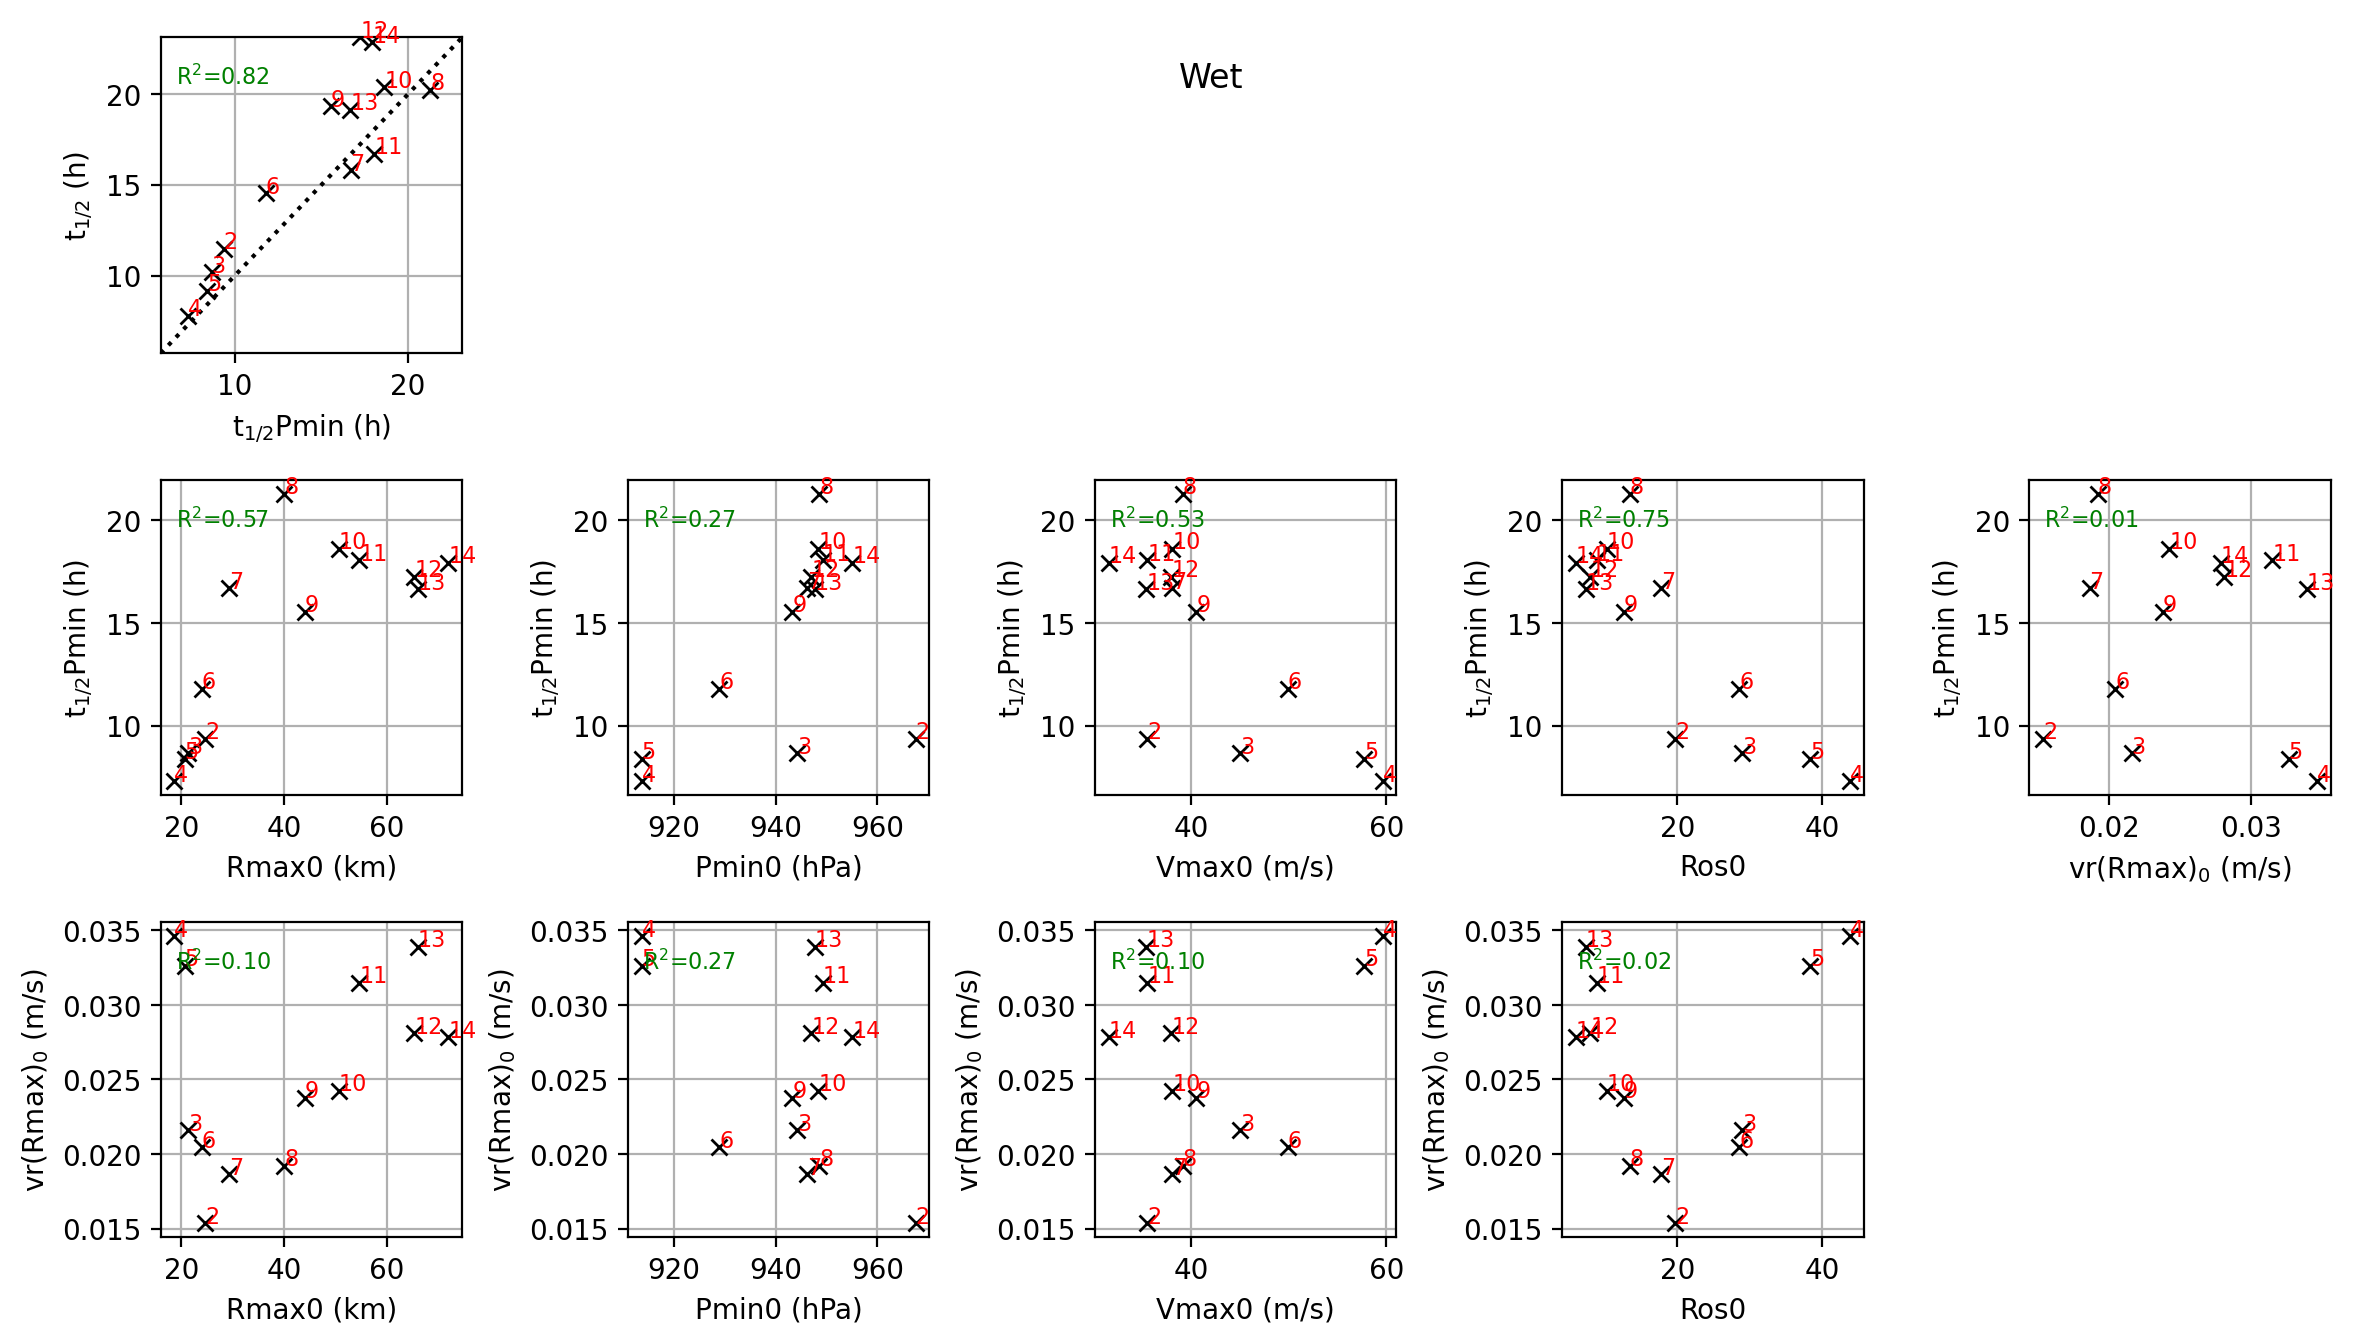

In [70]:
def plot_scat(ax,d):
    ax.plot(d.x.dat,d.y.dat,'xk')
    ax.grid(True)
    ax.set_xlabel(d.x.lab)
    ax.set_ylabel(d.y.lab)
    for tlf,x,y in zip(tlfs,d.x.dat,d.y.dat):
        ax.text(x,y,round(tlf),fontsize=fs,color='r')
    r2=np.corrcoef(d.x.dat,d.y.dat)[0,1]**2
    ax.text(0.05,0.85,"R$^2$={:2.2f}".format(r2),transform=ax.transAxes,fontsize=fs,color='g')
    if d.eq:
        axr=[np.min((d.x.dat,d.y.dat)),np.max((d.x.dat,d.y.dat))]
        axr[0]=axr[0]-0.1*(axr[1]-axr[0])
        axr[1]=axr[1]+0.1*(axr[1]-axr[~0])
        ax.plot(axr,axr,':k')
        ax.set_xlim(axr)
        ax.set_ylim(axr)
        
print('plotting scatters')
fs=8
fig,axs=plt.subplots(3,5,dpi=200,figsize=(14,6))
plt.subplots_adjust(hspace=0.4,wspace=0.55,top=1,bottom=0)
for i in range(1,5):
    axs.flatten()[i].axis('off')
        
pltdats=(
    Pltdat(vd['thP'],vd['tha'],True),
    
    Pltdat(vd['Rmax0'],vd['thP'],False),
    Pltdat(vd['Pmin0'],vd['thP'],False),
    Pltdat(vd['Vmax0'],vd['thP'],False),
    Pltdat(vd['Ros0'],vd['thP'],False),
    Pltdat(vd['vrRmax0'],vd['thP'],False),

    Pltdat(vd['Rmax0'],vd['vrRmax0'],False),
    Pltdat(vd['Pmin0'],vd['vrRmax0'],False),
    Pltdat(vd['Vmax0'],vd['vrRmax0'],False),
    Pltdat(vd['Ros0'],vd['vrRmax0'],False),  
#     Pltdat(vd['sqrtVmax0'],vd['vrRmax0'],False),

)

# if runstr=='Wet':
#     pltdats=pltdats+(
#         Pltdat(vd['thP'],vd['thR'],True),
#         Pltdat(vd['rmax'],vd['thR'],False),
# )

axs=np.delete(axs.flatten(),[1,2,3,4])
for ax,pltdat in zip(axs.flatten(),pltdats):
    plot_scat(ax,pltdat)
plt.suptitle(runstr);
for i in range(len(pltdats),len(axs.flat)):
    axs.flat[i].axis('off')